In [1]:
import sys
sys.path.append('../python')
import torch
from models import FashionCNN

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pickle
import os
import numpy as np

In [2]:
# Load metrics
data_dir = os.path.join(os.getcwd(), '../data')
metrics_file = os.path.join(data_dir, 'fashion_metrics.pkl')


with open(metrics_file, 'rb') as f:
    params_epochs = pickle.load(f)

In [3]:
# Plots params
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color

figs_dir = os.path.join(data_dir, '../figs')

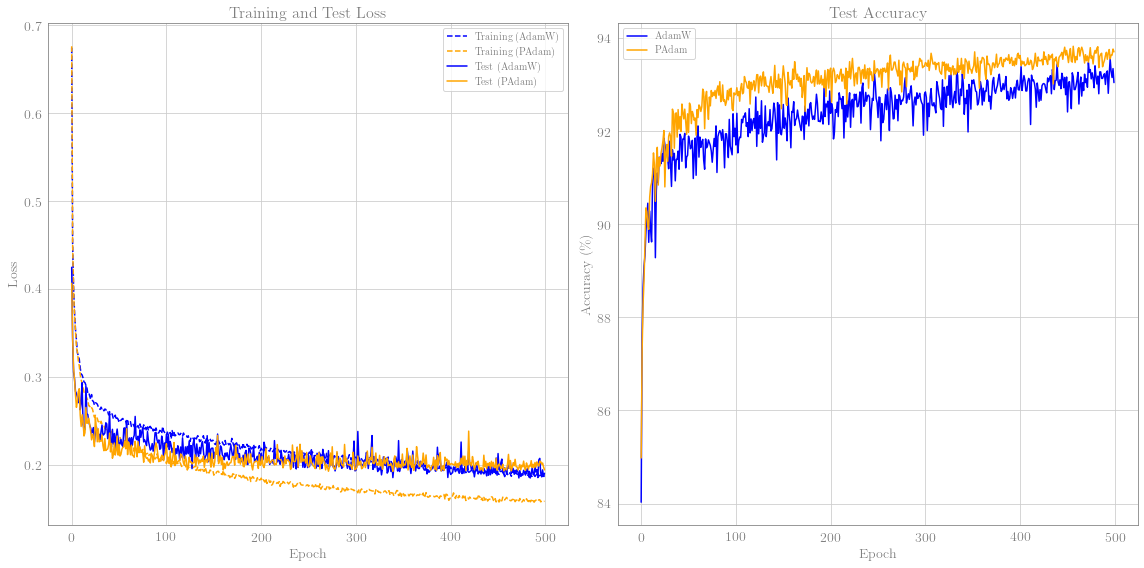

In [4]:
# Define the side-by-side subplot structure with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot training and test loss
ax1.plot(params_epochs['train_1'], label='Training (AdamW)', color='blue', ls='--')
ax1.plot(params_epochs['train_2'], label='Training (PAdam)', color='orange', ls='--')
ax1.plot(params_epochs['test_1'], label='Test (AdamW)', color='blue')
ax1.plot(params_epochs['test_2'], label='Test (PAdam)', color='orange')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Training and Test Loss', fontsize=16)
ax1.legend()

# Plot accuracy
ax2.plot(params_epochs['accuracy_1'], label='AdamW', color='blue')
ax2.plot(params_epochs['accuracy_2'], label='PAdam', color='orange')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (\%)', fontsize=14)
ax2.set_title('Test Accuracy', fontsize=16)
ax2.legend()

# Adjust layout
plt.tight_layout()

# Save the full figure
if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)
plt.savefig(os.path.join(figs_dir, 'fashion_padam_curves.png'), dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

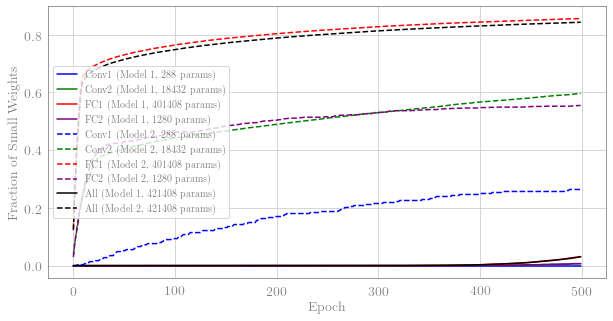

In [6]:
model = FashionCNN()
parameters_per_layer = [p.numel() for p in model.parameters() if p.requires_grad]


# Define the labels and colors for the layers you want to plot
layer_labels = ['Conv1', 'Conv2', 'FC1', 'FC2']
layer_colors = ['blue', 'green', 'red', 'purple']

# Extract the number of parameters for weights only
num_params_weights = parameters_per_layer[::2]  # Taking every second element

# Plot for the fraction of small weights per layer for Model 1
plt.figure(figsize=(10, 5))

for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
    # Extract fractions for the i-th weight layer across all epochs for Model 1
    fractions = [epoch_fractions[2*i] for epoch_fractions in params_epochs['small_weights_1']]
    plt.plot(fractions, label=f'{label} (Model 1, {num_params_weights[i]} params)', color=color, ls='-')

# Plot for the fraction of small weights per layer for Model 2
for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
    # Extract fractions for the i-th weight layer across all epochs for Model 2
    fractions = [epoch_fractions[2*i] for epoch_fractions in params_epochs['small_weights_2']]
    plt.plot(fractions, label=f'{label} (Model 2, {num_params_weights[i]} params)', color=color, ls='--')

# Plot the overall weighted fraction of small weights for comparison for both models
weighted_fractions_1 = [frac[-1] for frac in params_epochs['small_weights_1']]
weighted_fractions_2 = [frac[-1] for frac in params_epochs['small_weights_2']]
plt.plot(weighted_fractions_1, label=f'All (Model 1, {np.sum(num_params_weights)} params)', color='black', ls='-')
plt.plot(weighted_fractions_2, label=f'All (Model 2, {np.sum(num_params_weights)} params)', color='black', ls='--')

# Adding labels and title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Fraction of Small Weights', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


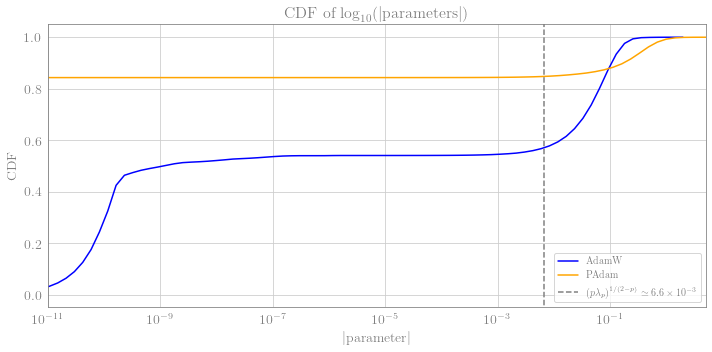

In [10]:
# Function to extract parameters and compute log10(abs(param))
def get_parameters_log10(model):
    params = [p.data.view(-1).cpu().numpy() for p in model.parameters() if p.requires_grad]
    params = np.concatenate(params)  # Flatten the parameters
    return np.log10(np.abs(params) + 1e-15)  # Add a small constant to avoid log10(0)

# Function to calculate CDF
def calculate_cdf(data, bins=100):
    count, bin_edges = np.histogram(data, bins=bins)
    cdf = np.cumsum(count)
    return bin_edges[1:], cdf / cdf[-1]  # Normalize

# Load the models
model_1 = FashionCNN()
model_1.load_state_dict(torch.load(f'{data_dir}/fashion_Model_1.pth'))
model_2 = FashionCNN()
model_2.load_state_dict(torch.load(f'{data_dir}/fashion_Model_2.pth'))

# Get the log10(abs(parameters)) for each model
log_params_1 = get_parameters_log10(model_1)
log_params_2 = get_parameters_log10(model_2)

# Calculate CDF for each model
bins_edges_1, cdf_1 = calculate_cdf(log_params_1)
bins_edges_2, cdf_2 = calculate_cdf(log_params_2)

# Plot CDF
plt.figure(figsize=(10, 5))


plt.plot(10**bins_edges_1, cdf_1, label='AdamW',color='blue')
plt.plot(10**bins_edges_2, cdf_2, label='PAdam',color='orange')
plt.axvline((0.8*3e-3)**(1/(2-0.8)),-1,2,ls='--', color=text_and_line_color,label=r'$\left(p\lambda_p\right)^{1/(2-p)}\simeq6.6\times 10^{-3}$')
plt.xlabel('$|\mathrm{parameter}|$', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.title('CDF of $\log_{10}(|\mathrm{parameters}|)$', fontsize=16)
plt.legend()
plt.xscale('log')
plt.xlim(1e-11,0.5e1)
plt.grid(True)


plt.tight_layout()
plt.savefig('../figs/fashion_padam_cdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()



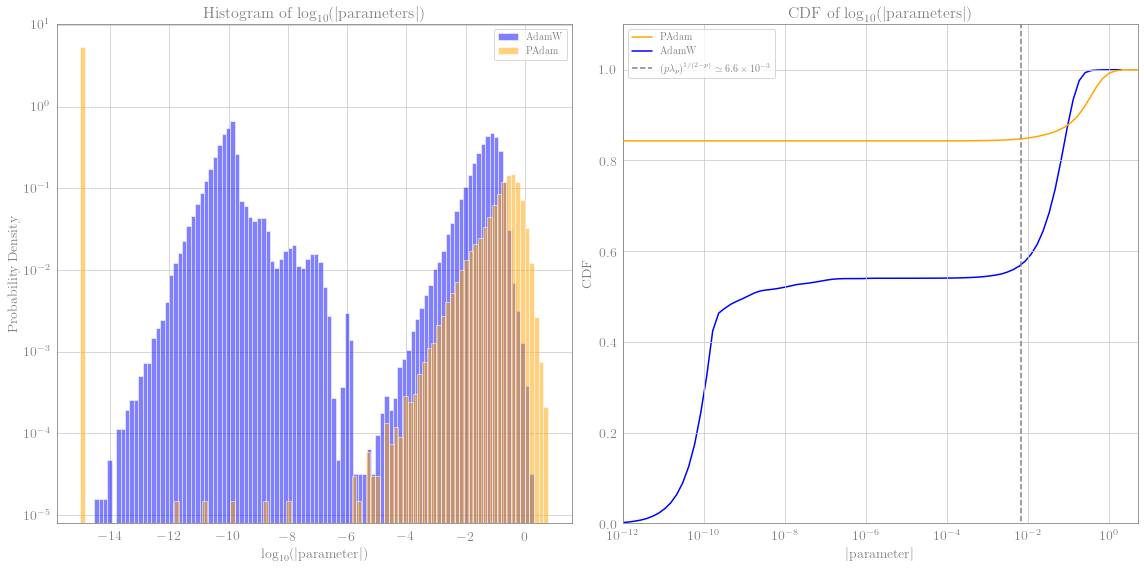

In [21]:
# Creating a two-panel plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot histograms (PDF) on the first axis
ax1.hist(log_params_1, bins=100, alpha=0.5, label='AdamW', density=True, color='blue')
ax1.hist(log_params_2, bins=100, alpha=0.5, label='PAdam', density=True, color='orange')
ax1.set_xlabel('$\log_{10}(|\mathrm{parameter}|)$', fontsize=14)
ax1.set_ylabel('Probability Density', fontsize=14)
ax1.set_title('Histogram of $\log_{10}(|\mathrm{parameters}|)$', fontsize=16)
ax1.legend()
ax1.grid(True)
ax1.set_yscale('log')

# Plot CDFs on the second axis
ax2.plot(10**bins_edges_2, cdf_2, label='PAdam', color='orange',zorder=10)
ax2.plot(10**bins_edges_1, cdf_1, label='AdamW', color='blue',zorder=-10)
ax2.axvline((0.8*3e-3)**(1/(2-0.8)), -1, 2, ls='--', color='grey', label=r'$\left(p\lambda_p\right)^{1/(2-p)}\simeq6.6\times 10^{-3}$')
ax2.set_xlabel('$|\mathrm{parameter}|$', fontsize=14)
ax2.set_ylabel('CDF', fontsize=14)
ax2.set_title('CDF of $\log_{10}(|\mathrm{parameters}|)$', fontsize=16)
ax2.legend()
ax2.set_xscale('log')
ax2.set_xlim(1e-12,0.5e1)
ax2.set_ylim(0,1.1)
ax2.grid(True)

plt.tight_layout()
plt.savefig(f'{data_dir}/../figs/fashion_padam_pdf_cdf.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()